<a href="https://colab.research.google.com/github/fulllz/DSProjects/blob/main/Project_5_Multi_label_text_classification_with_Scikit_Learning_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 5 Multi label text classification**

In this project, I am going to look into Multi-Label Text Classification. It is a problem of mapping inputs (x) to a set of target labels (y), which are not mutually exclusive. Multi-label text classification has many real world applications such as categorizing businesses on Yelp or classifying movies into one or more genre(s).  In contrast with the binary classification problem, where the goal is to predict whether the customer is churn or not. Or multi-class classification means a classification task with more than two classes; each label are mutually exclusive. 

The multi-label models were built that can detect different types of toxicity like severe toxic, threats, obscenity, insults, and so on. We will be using supervised classifiers and text representations. The data set can be found at Kaggle. For each comment/post, it has six corresponding classes (labels):  
– Toxic  
– Severe Toxic  
– Obscene  
– Threat  
– Insult  
– Identity Hate  
The objective for this task is to identify if a comment belongs to any of these classes (can be mutiple). 

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, hamming_loss

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import io
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [ ]:
train.shape

(159571, 8)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.duplicated().sum()

0

In [ ]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# <font color=red>**Part-1 Multi label text classification with Scikit-learning** </font>

In [ ]:
df =train.copy()

In [ ]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
counts = []
for col in cols:
    counts.append((col, df[col].sum()))

In [ ]:
counts

[('toxic', 15294),
 ('severe_toxic', 1595),
 ('obscene', 8449),
 ('threat', 478),
 ('insult', 7877),
 ('identity_hate', 1405)]

In [ ]:
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


In [ ]:
df_stats.sort_values(by='number_of_comments', ascending=False)

,category,number_of_comments
0,toxic,15294
2,obscene,8449
4,insult,7877
1,severe_toxic,1595
5,identity_hate,1405
3,threat,478


In [ ]:
total = df_stats['number_of_comments'].sum()
total

35098

In [ ]:
df_stats['percent_of_comments(%)'] = df_stats['number_of_comments'].apply(lambda x: (x/total*100))

In [ ]:
df_stats['percent_of_comments(%)'] = df_stats['percent_of_comments(%)'].round(2)
df_stats

,category,number_of_comments,percent_of_comments(%)
0,toxic,15294,43.58
1,severe_toxic,1595,4.54
2,obscene,8449,24.07
3,threat,478,1.36
4,insult,7877,22.44
5,identity_hate,1405,4.00


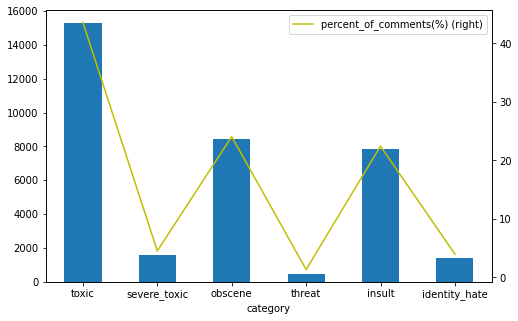

In [ ]:
ax1=df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
df_stats.plot(x='category', y='percent_of_comments(%)', kind='line', color='y',secondary_y= True, ax=ax1)

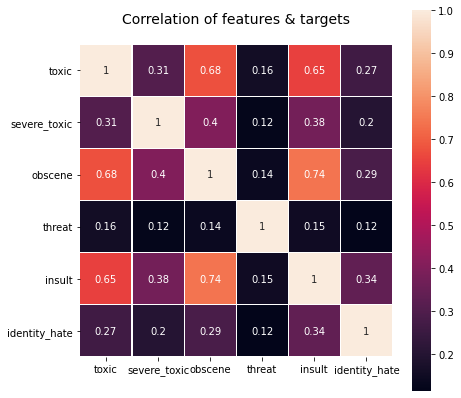

In [ ]:
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(df[cols].corr(), annot=True, vmax=1.0, 
            linewidths=0.1, linecolor='white', square=True )

It looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene at 0.68 and toxic-insult at 0.65 .

### Multi-Label

How many comments have multiple labels?

In [ ]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

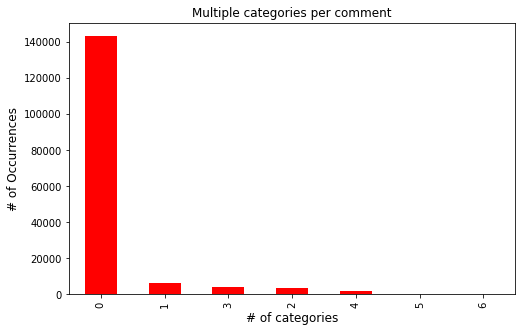

In [ ]:
#plot
plt.figure(figsize=(8,5))
ax = x.plot(kind='bar',color='r')
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)
plt.show()

Vast majority of the comment texts are not labeled.

The distribution of the number of words in comment texts.

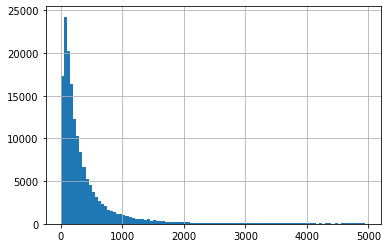

In [ ]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50));

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [ ]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


**Looking at some examples of the  comments, the text needs clean.**

In [ ]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

**Create a function to clean the text**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [ ]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [ ]:
df['comment_text'][10]

'fair use rationale for image wonju jpg thanks for uploading image wonju jpg i notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in wikipedia articles constitutes fair use in addition to the boilerplate fair use template you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use please go to the image description page and edit it to include a fair use rationale if you have uploaded other fair use media consider checking that you have specified the fair use rationale on those pages too you can find a list of image pages you have edited by clicking on the my contributions link it is located at the very top of any wikipedia page when you are logged in and then selecting image from the dropdown box note that any fair use images uploaded after 4 may 2006 and lacking such an explanation will be deleted one wee

### Split to train and test sets

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [ ]:
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


### OneVsRest multilabel strategy

**Binary Relevance**  
- In Binary Relevance, an ensemble of single-label binary classifiers is trained independently on the original dataset to predict a membership to each class.
- Example: If there’s q labels, the binary relevance method create q new data sets from the dataset, one for each label and train single-label classifiers on each new data set.

**One-vs-Rest**  
- Here strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives.
- It’s more or less similar to Binary Relevance except a fact that One-vsRest works on mutually exclusive labels.

**Label Power Set**
- This approach does take possible correlations between class labels into account meaning it maps each combination of labels into a single label and trains a single label classifier.
- As the number of classes increases distinct label combinations grows exponentially.

OneVsRest multilabel strategy are applied here.


In [ ]:
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

### Naive Bayes

OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [ ]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    metricsReport("Naive Bayes", test[category], prediction)
    print()

... Processing toxic
------Naive Bayes Model Metrics-----
Accuracy: 0.9193
Hamming Loss: 0.0807
Precision:
  - Macro: 0.9544
  - Micro: 0.9193
Recall:
  - Macro: 0.5828
  - Micro: 0.9193
F1-measure:
  - Macro: 0.6207
  - Micro: 0.9193

... Processing severe_toxic
------Naive Bayes Model Metrics-----
Accuracy: 0.9900
Hamming Loss: 0.0100
Precision:
  - Macro: 0.4950
  - Micro: 0.9900
Recall:
  - Macro: 0.5000
  - Micro: 0.9900
F1-measure:
  - Macro: 0.4975
  - Micro: 0.9900

... Processing obscene
------Naive Bayes Model Metrics-----
Accuracy: 0.9516
Hamming Loss: 0.0484
Precision:
  - Macro: 0.9688
  - Micro: 0.9516
Recall:
  - Macro: 0.5506
  - Micro: 0.9516
F1-measure:
  - Macro: 0.5795
  - Micro: 0.9516

... Processing threat
------Naive Bayes Model Metrics-----
Accuracy: 0.9971
Hamming Loss: 0.0029
Precision:
  - Macro: 0.9986
  - Micro: 0.9971
Recall:
  - Macro: 0.5033
  - Micro: 0.9971
F1-measure:
  - Macro: 0.5058
  - Micro: 0.9971

... Processing insult
------Naive Bayes Model 

### LinearSVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])


for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    metricsReport("LinearSVC", test[category], prediction)
    print()

... Processing toxic
------LinearSVC Model Metrics-----
Accuracy: 0.9599
Hamming Loss: 0.0401
Precision:
  - Macro: 0.9202
  - Micro: 0.9599
Recall:
  - Macro: 0.8367
  - Micro: 0.9599
F1-measure:
  - Macro: 0.8726
  - Micro: 0.9599

... Processing severe_toxic
------LinearSVC Model Metrics-----
Accuracy: 0.9906
Hamming Loss: 0.0094
Precision:
  - Macro: 0.7778
  - Micro: 0.9906
Recall:
  - Macro: 0.6396
  - Micro: 0.9906
F1-measure:
  - Macro: 0.6852
  - Micro: 0.9906

... Processing obscene
------LinearSVC Model Metrics-----
Accuracy: 0.9789
Hamming Loss: 0.0211
Precision:
  - Macro: 0.9350
  - Micro: 0.9789
Recall:
  - Macro: 0.8454
  - Micro: 0.9789
F1-measure:
  - Macro: 0.8844
  - Micro: 0.9789

... Processing threat
------LinearSVC Model Metrics-----
Accuracy: 0.9975
Hamming Loss: 0.0025
Precision:
  - Macro: 0.8215
  - Micro: 0.9975
Recall:
  - Macro: 0.6314
  - Micro: 0.9975
F1-measure:
  - Macro: 0.6863
  - Micro: 0.9975

... Processing insult
------LinearSVC Model Metrics---

### Logistic Regression

In [ ]:
LogReg_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),
                            ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))
                           ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    metricsReport("LogisticRegression", test[category], prediction)
    print()

... Processing toxic
------LogisticRegression Model Metrics-----
Accuracy: 0.9549
Hamming Loss: 0.0451
Precision:
  - Macro: 0.9432
  - Micro: 0.9549
Recall:
  - Macro: 0.7860
  - Micro: 0.9549
F1-measure:
  - Macro: 0.8437
  - Micro: 0.9549

... Processing severe_toxic
------LogisticRegression Model Metrics-----
Accuracy: 0.9911
Hamming Loss: 0.0089
Precision:
  - Macro: 0.8102
  - Micro: 0.9911
Recall:
  - Macro: 0.6276
  - Micro: 0.9911
F1-measure:
  - Macro: 0.6799
  - Micro: 0.9911

... Processing obscene
------LogisticRegression Model Metrics-----
Accuracy: 0.9761
Hamming Loss: 0.0239
Precision:
  - Macro: 0.9528
  - Micro: 0.9761
Recall:
  - Macro: 0.8000
  - Micro: 0.9761
F1-measure:
  - Macro: 0.8591
  - Micro: 0.9761

... Processing threat
------LogisticRegression Model Metrics-----
Accuracy: 0.9974
Hamming Loss: 0.0026
Precision:
  - Macro: 0.8536
  - Micro: 0.9974
Recall:
  - Macro: 0.5723
  - Micro: 0.9974
F1-measure:
  - Macro: 0.6196
  - Micro: 0.9974

... Processing ins

### Bagging Classifier

In [ ]:
bag_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(BaggingClassifier(n_jobs=-1))),
                 ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    bag_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = bag_pipeline.predict(X_test)
    metricsReport("Bagging", test[category], prediction)
    print()

... Processing toxic
------Bagging Model Metrics-----
Accuracy: 0.9518
Hamming Loss: 0.0482
Precision:
  - Macro: 0.8775
  - Micro: 0.9518
Recall:
  - Macro: 0.8327
  - Micro: 0.9518
F1-measure:
  - Macro: 0.8532
  - Micro: 0.9518

... Processing severe_toxic
------Bagging Model Metrics-----
Accuracy: 0.9892
Hamming Loss: 0.0108
Precision:
  - Macro: 0.6933
  - Micro: 0.9892
Recall:
  - Macro: 0.5758
  - Micro: 0.9892
F1-measure:
  - Macro: 0.6081
  - Micro: 0.9892

... Processing obscene
------Bagging Model Metrics-----
Accuracy: 0.9779
Hamming Loss: 0.0221
Precision:
  - Macro: 0.9025
  - Micro: 0.9779
Recall:
  - Macro: 0.8730
  - Micro: 0.9779
F1-measure:
  - Macro: 0.8871
  - Micro: 0.9779

... Processing threat
------Bagging Model Metrics-----
Accuracy: 0.9972
Hamming Loss: 0.0028
Precision:
  - Macro: 0.7807
  - Micro: 0.9972
Recall:
  - Macro: 0.6017
  - Micro: 0.9972
F1-measure:
  - Macro: 0.6491
  - Micro: 0.9972

... Processing insult
------Bagging Model Metrics-----
Accurac

In [ ]:
df_summary = pd.DataFrame({'Model name':['Naive Bayes', 'Linear SVC','Logistic Regression', 'Bagging Classifier'], 
                           'toxic(Macro-F1)':[0.62, 0.87, 0.84,0.85], 'toxic(Micro-F1)':[0.91, 0.95, 0.95, 0.95],
                           'severe_toxic(Macro-F1)':[0.49, 0.68, 0.67, 0.60 ], 'severe_toxic(Micro-F1)':[0.99, 0.99, 0.99, 0.98],
                           'obscene(Macro-F1)':[0.57, 0.88, 0.85, 0.88], 'obscene(Micro-F1)':[0.95,0.97, 0.97, 0.97],
                           'threat(Macro-F1)':[0.50, 0.68, 0.61, 0.64], 'threat(Micro-F1)':[0.99, 0.99,0.99, 0.99],
                           'insult(Macro-F1)':[0.52, 0.82, 0.79, 0.81], 'insult(Micro-F1)':[0.95,0.97, 0.96, 0.96],
                           'identity_hate(Macro-F1)':[0.49,0.67, 0.61,0.68], 'identity_hate(Macro-F1)':[0.99,0.99, 0.99, 0.99]
})
df_summary

,Model name,toxic(Macro-F1),toxic(Micro-F1),severe_toxic(Macro-F1),severe_toxic(Micro-F1),obscene(Macro-F1),obscene(Micro-F1),threat(Macro-F1),threat(Micro-F1),insult(Macro-F1),insult(Micro-F1),identity_hate(Macro-F1)
0,Naive Bayes,0.62,0.91,0.49,0.99,0.57,0.95,0.50,0.99,0.52,0.95,0.99
1,Linear SVC,0.87,0.95,0.68,0.99,0.88,0.97,0.68,0.99,0.82,0.97,0.99
2,Logistic Regression,0.84,0.95,0.67,0.99,0.85,0.97,0.61,0.99,0.79,0.96,0.99
3,Bagging Classifier,0.85,0.95,0.60,0.98,0.88,0.97,0.64,0.99,0.81,0.96,0.99


Based on the results we can see that Linear SVC has the best performance.

Here We have compared various Machine learning based classifiers for Multi-label text classification with TF-IDF feature extraction.

Next Steps:
We will use Deep learning based approaches (LSTM)

# <font color=red>**Part-2 Multi label text classification with Keras** </font>

In [ ]:
y = df[categories].values
trainComments = df["comment_text"]

## data preprocessing

Before feeding data from raw dataset (sentences) into the model, it has
to be preprocessed by:

1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"].  
2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}.  
3. Text to Sequence, which represents the sequence of words in the comments
in the form of index, and feed this series of index into LSTM model. eg, [1,2,3,4,2,5].

Some comments looks like very long, some just few words. It looks like:
   
  Comment #1: [7,8,9,3,7,3,6,3,6,3,6,2,3,4,9, 10, 11]
  
  Comment #2: [1,2,5]

we have to feed a stream of data that has a consistent length(fixed number of features),  we will use padding. It could make the shorter sentences as long as the others by filling the shortfall by zeros. On the other hand,  It could trim the longer ones to the same length(maxlen) as the short ones.

In [ ]:
max_features = 20000
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(list(trainComments))
trainComments_tokenized = tok.texts_to_sequences(trainComments)

maxlen = 200
X_t = pad_sequences(trainComments_tokenized, maxlen=maxlen)

## Neural Network Construction

1. Use an embedding layer to project each integer word index to a vector space, which training will adjust so that more closely associated words are closer in space.  
2. These vectors serve as input to a long short-term memory RNN layer. This layer represents a neural network with memory which is capable of classifying long sequences of data, such as our embedded comments.   
3. We then use a pooling layer to reduce the LSTM's 3d output to 2D. 
4. and pass it through a standard neural network, which consists of two dense layers and two 1/10 dropout layers. We use the sigmoid activation function on the final layer to recieve 6 outputs between 0 and 1.
5. and use the binary_crossentropy loss function, as each of the 6 outputs is a binary classification. 
6. We create an early-stopping callback so that training can be stopped after a single epoch if loss stopps decreasing.

In [ ]:
#input layer for an arbitrary number of comments of length commentLen
input = Input(shape=(maxlen, ))
#project words to coordinate vector space
x = Embedding(max_features, 128)(input)
#stateful recurrent neural network
x = LSTM(60, return_sequences = True, name = "lstm")(x)
#reduce 3d vector space output to 2d
x = GlobalMaxPool1D()(x)
#drop 1/10 nodes to improve generalization
x = Dropout(0.1)(x)
#standard nn
x = Dense(50, activation='relu')(x)
#drop again
x = Dropout(rate=0.1)(x)
#standard nn, sigmoid for values between 0 and 1
x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
earlyStoppingCallback = [EarlyStopping(monitor='val_loss', min_delta=0, mode='min', restore_best_weights=True)]

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

## Building the model

In [ ]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=.1, callbacks=earlyStoppingCallback)

Epoch 1/2
4488/4488 [==============================] - 685s 153ms/step - loss: 0.0682 - accuracy: 0.9538 - val_loss: 0.0494 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 683s 152ms/step - loss: 0.0450 - accuracy: 0.9887 - val_loss: 0.0472 - val_accuracy: 0.9919


In [ ]:
preds = model.predict(X_t[:500])

## Prediction


In [ ]:
print(trainComments[0])
print(preds[0])
print(trainComments[55])
print(preds[55])

explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27
[4.9895048e-04 3.8998101e-07 1.2922287e-04 1.3563134e-06 3.3418553e-05
 1.6178661e-05]
stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell
[0.99933666 0.5096289  0.97274256 0.15241978 0.9103379  0.3843939 ]


In [ ]:
print(y[0])
print(y[55])

[0 0 0 0 0 0]
[1 1 1 0 1 0]
